# 학습 목표
1. Single-cell RNA 시퀀싱(scRNA-seq) 핵심 개념을 이해한다
2. Single-cell RNA-seq의 이론적 배경 이해  
3. 실제 GEO 데이터(GSE92332) 다운로드 및 파일 구조 파악  
4. 간단한 전처리(품질 관리, 정규화)와 차원 축소(PCA 등)  
5. 클러스터링 방법(UMAP/t-SNE) 살펴보기


In [ ]:
!pip install scanpy
!pip install igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1



# 1. 단일세포 RNA-seq(scRNA-seq) 이론 개요

### 1.1 단일세포 RNA-seq란?
- **정의**: RNA 시퀀싱 기법을 단일 세포 수준으로 적용하여, 세포마다 발현되는 유전자 정보를 정밀하게 측정
- **장점**: 세포 아형(subpopulation) 발굴, 희귀 세포 검출, 동적 세포 상태 추적 등이 가능
- **적용분야**: 종양 미세환경 해석, 세포 분화 연구, 면역학, 신약 타겟 발굴 등

### 1.2 전처리(품질관리, QC)와 정규화
- 세포별로 **라이브러리 사이즈**(total counts), **미토콘드리아 유전자 비율**, **이중 중첩(doublet) 여부** 등을 점검 (QC)
- 라이브러리 사이즈 정규화 후 **log 변환** 등의 방법으로 잡음 영향 감소 및 해석 용이성 향상

### 1.3 차원 축소와 클러스터링
- scRNA-seq는 고차원(세포 수천/수만 × 유전자 수천/수만)이므로, **PCA**, **t-SNE**, **UMAP** 등으로 차원 축소
- **클러스터링**(K-means, Louvain, Leiden 등)을 통해 세포 집단(아형)을 분류하고, 각 클러스터 특이 유전자를 해석

---

# 2. GSE92332 데이터 개요

- **논문**: Haber AL, et al. "A single-cell survey of the small intestinal epithelium."  
- **GEO Accession**: [GSE92332](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92332)  
- 이 데이터는 마우스 소장의 상피 조직에서 얻은 단일세포 RNA-seq 데이터로,  
  다양한 조건(Duodenum, Jejunum, Ileum, LargeCell, Salmonella, 등등)과 반복(Rep1, Rep2, ...)별로 수십 개의 파일로 구성됩니다.

### 2.1 파일 구조
GSE92332 원시 데이터는 GEO에서 다운로드하면, 아래와 같은 `(barcodes.tsv.gz, genes.tsv.gz, matrix.mtx.gz)` 파일들이 다수 존재합니다.

예:  
- `GSM2836573_Regional_Duo_M1_barcodes.tsv.gz`  
- `GSM2836573_Regional_Duo_M1_genes.tsv.gz`  
- `GSM2836573_Regional_Duo_M1_matrix.mtx.gz`  
- ...

각 세트는 하나의 실험 샘플(조건 & 반복)에 해당하며,  
- **barcodes.tsv.gz**: 세포 바코드 정보 (Cell ID)  
- **genes.tsv.gz**: 유전자(피처) 정보  
- **matrix.mtx.gz**: 세포 × 유전자 발현 매트릭스 (희소행렬)

분석 시, 보통 한 폴더에 이 세 파일이 함께 들어있도록 하여 `scanpy.read_10x_mtx()` 같은 함수로 불러옵니다.


# 3. 데이터 다운로드 & 폴더 구조 세팅

In [ ]:
%%bash

# 1. 필요한 디렉토리 생성 및 다운로드
mkdir -p data/Haber-et-al_mouse-intestinal-epithelium/
cd data/Haber-et-al_mouse-intestinal-epithelium/

echo "Downloading data from GEO..."
wget -q ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE92nnn/GSE92332/suppl/GSE92332_RAW.tar

echo "Unpacking tar..."
mkdir -p GSE92332_RAW
tar -xf GSE92332_RAW.tar -C GSE92332_RAW

# 2. .gz 파일을 폴더로 분류 (압축 해제 X)
cd GSE92332_RAW
for f in *.gz; do
  # 파일명에서 첫 번째 언더바 전까지(예: GSM2836573)를 폴더 이름으로 추출
  sample="$(echo "$f" | cut -d '_' -f 1)"

  mkdir -p "$sample"
  mv "$f" "$sample/"
done

# 3. 폴더별로 파일명을 일괄 변경 (barcodes, features, matrix로)
for sample_dir in GSM*; do
  if [ -d "$sample_dir" ]; then
    cd "$sample_dir"
    for gz_file in *.gz; do
      case "$gz_file" in
        *_barcodes.tsv.gz) mv "$gz_file" barcodes.tsv.gz ;;
        *_genes.tsv.gz)    mv "$gz_file" features.tsv.gz ;;
        *_matrix.mtx.gz)   mv "$gz_file" matrix.mtx.gz ;;
      esac
    done
    cd ..
  fi
done

echo "Done!"


Unpacking tar...
Done!


# 4. scanpy를 이용한 10x 포맷 파일 읽기

scanpy 라이브러리를 사용하여, 10x 형식의 (barcodes, genes, matrix)를 읽고 AnnData 객체로 변환함.

In [ ]:
import scanpy as sc
import pandas as pd
from scipy.io import mmread

def get_adata(sample_folder):
    # 1) 희소행렬 읽기 (기본적으로 (genes, cells) 구조)
    X = mmread(f"{sample_folder}/matrix.mtx.gz")

    # 2) (cells, genes) 구조로 바꿔주기 위해 전치
    X = X.T.tocsr()
    # 이제 X.shape는 (2348, 27998)처럼 (세포, 유전자) 가 됩니다.

    # 3) 바코드(세포) 읽기
    barcodes = pd.read_csv(
        f"{sample_folder}/barcodes.tsv.gz",
        header=None, sep='\t'
    )[0].values  # 첫 번째 열만 가져옴

    # 4) 유전자 정보(2열 구조: 첫 번째 열 gene_id, 두 번째 열 gene_symbol)
    genes_df = pd.read_csv(
        f"{sample_folder}/features.tsv.gz",
        header=None, sep='\t'
    )
    gene_ids = genes_df.iloc[:, 0].values
    gene_symbols = genes_df.iloc[:, 1].values

    # 5) AnnData 객체 생성
    adata = sc.AnnData(X=X)

    #    - obs_names: 세포 이름 (2348개)
    adata.obs_names = barcodes

    #    - var_names: 유전자 이름 (27998개)
    adata.var_names = gene_symbols  # 또는 gene_ids

    return adata

sample_folder = './data/Haber-et-al_mouse-intestinal-epithelium/GSE92332_RAW/GSM2836573'
adata = get_adata(sample_folder)
print(adata)
# 출력: AnnData object with n_obs × n_vars = (세포수) × (유전자수)
# obs: 'barcode'
# var: 'gene_name' or etc.

AnnData object with n_obs × n_vars = 2348 × 27998


# 5. 전처리 & QC
통상적으로 미토 유전자 비율이 높거나, 총 발현량이 극단적인 세포를 제거
- 세포별 총 카운트(라이브러리 사이즈)
- 미토콘드리아 유전자 비율
- 발현 유전자 수 (유의미하게 발현되는 유전자 개수)

In [ ]:
# 1) var_names에서 'mt-' 접두사 여부를 확인해 mt 컬럼 생성
adata.var['mt'] = adata.var_names.str.startswith('mt-')

# 2) 이후 QC metrics 계산할 때 qc_vars=['mt'] 지정
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt'],  # 이제 var['mt'] 불리언 값을 참조
    percent_top=None,
    log1p=False,
    inplace=True
)

# 필터링
sc.pp.filter_cells(adata, min_counts=500) # 총 유전자 카운트(UMI)가 500 미만인 세포들을 제거
sc.pp.filter_genes(adata, min_cells=10) # 특정 유전자가 등장(검출)한 세포 수가 10 미만이면 그 유전자를 제거

# 6. 정규화 & 로그 변환
- 세포별 라이브러리 사이즈에 따라 발현량을 정규화하고(log1p 변환 포함),
이후 분석 안정성을 높이기 위한 스케일링 등을 수행할 수 있음.
- adata.X에 정규화된 발현량이 저장

In [ ]:
# 예: CPM + log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4099097 stored elements and shape (2348, 11695)>

# 7. 차원 축소(PCA)
고차원 데이터를 PCA로 차원 축소하여,
세포 분포를 시각적으로 파악하거나 후속 클러스터링에 활용.

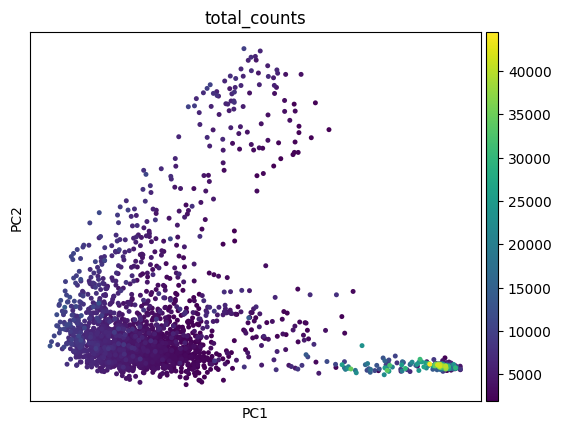

In [ ]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_scatter(adata, color='total_counts')

# 8. 클러스터링 & UMAP
PCA 결과를 바탕으로 근접 그래프를 계산하고,
Louvain/Leiden 클러스터링 알고리즘을 통해 세포 군집을 식별한 뒤, UMAP 등을 사용해 시각화.

In [ ]:
# 근접 그래프 계산 및 클러스터링
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, resolution=0.5)

<ipython-input-28-dbca3c17fa0c>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


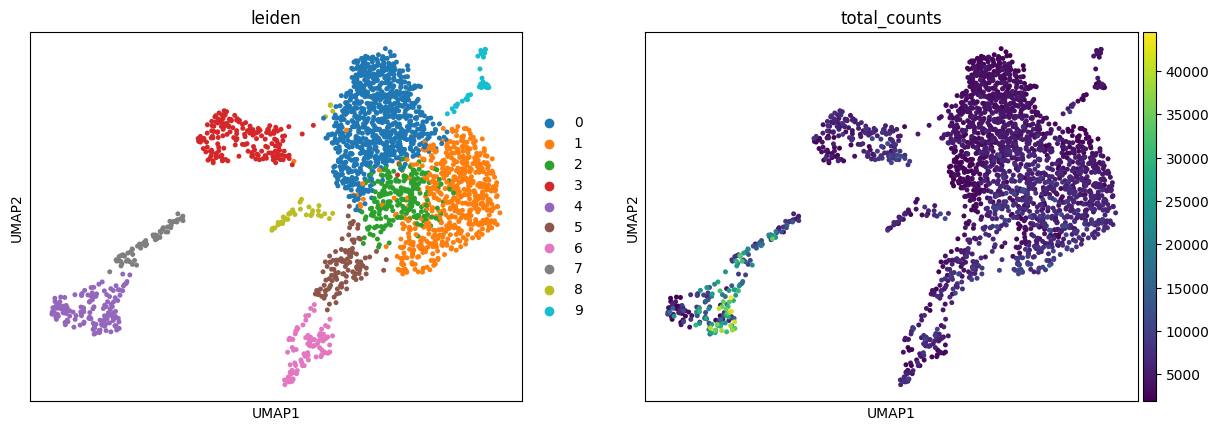

In [ ]:
# UMAP 시각화
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden', 'total_counts'])

# 9. 클러스터별 세포 타입 주석
마커 유전자 발현 상태를 확인해, 클러스터별로 어떤 세포 타입(Paneth, Goblet, Enterocyte 등)에 해당하는지 추론.

In [ ]:
adata.var_names

Index(['mm10_Mrpl15', 'mm10_Lypla1', 'mm10_Tcea1', 'mm10_Atp6v1h',
       'mm10_Rb1cc1', 'mm10_4732440D04Rik', 'mm10_St18', 'mm10_Pcmtd1',
       'mm10_Gm26901', 'mm10_Rrs1',
       ...
       'mm10_mt-Co3', 'mm10_mt-Nd4', 'mm10_mt-Nd5', 'mm10_mt-Nd6',
       'mm10_mt-Cytb', 'mm10_Vamp7', 'mm10_Spry3', 'mm10_Tmlhe', 'mm10_PISD',
       'mm10_DHRSX'],
      dtype='object', length=11695)

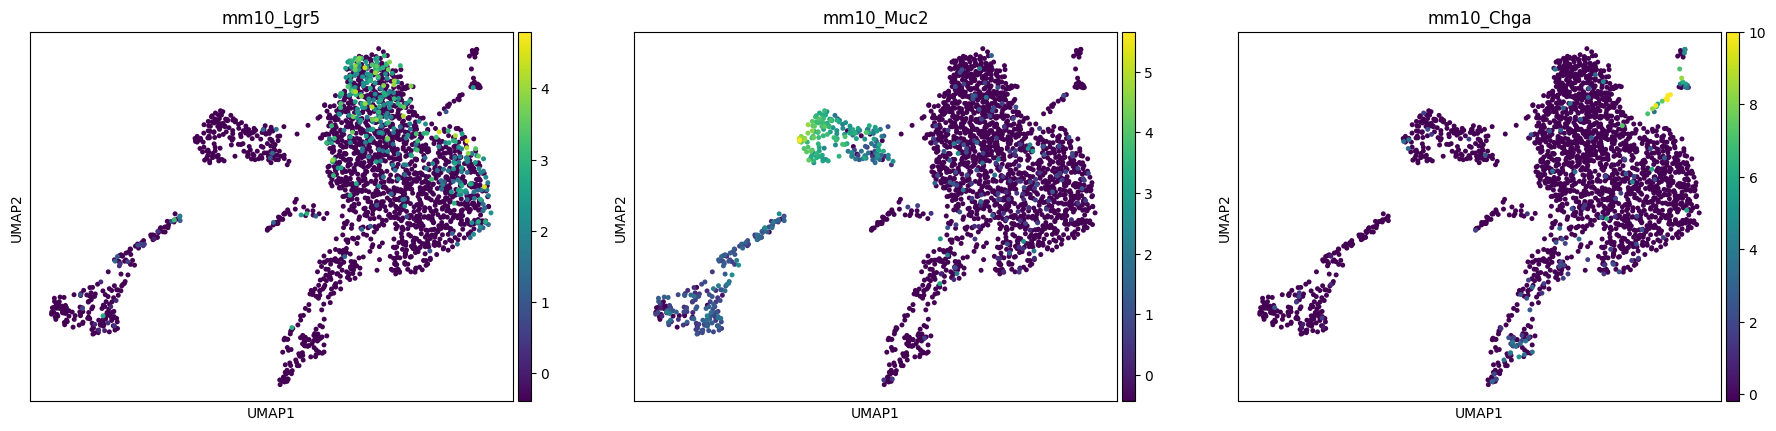

In [ ]:
# 주요 마커 유전자 발현 시각화
sc.pl.umap(adata, color=['mm10_Lgr5', 'mm10_Muc2', 'mm10_Chga'], use_raw=False)

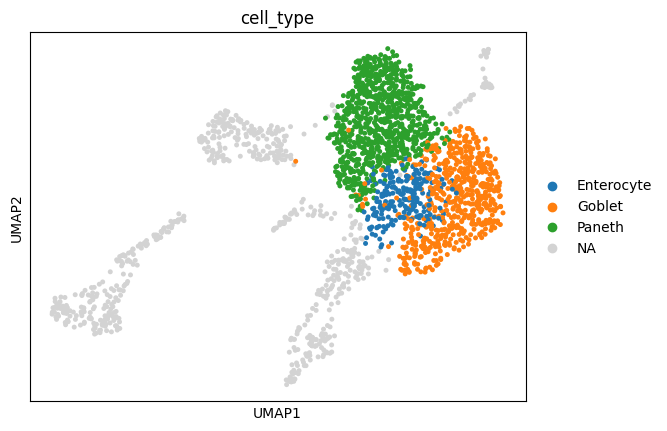

In [ ]:
cell_type_map = {
    '0': 'Paneth',
    '1': 'Goblet',
    '2': 'Enterocyte'
}

adata.obs['cell_type'] = adata.obs['leiden'].map(cell_type_map)
sc.pl.umap(adata, color=['cell_type'])

# 10. 클러스터별 차등 발현 유전자(DEG) 찾기
- 클러스터 간에 발현량이 유의하게 다른 유전자(마커)를 찾는 과정.
- 찾은 DEG 중에서 생물학적으로 알려진 Marker 유전자와 일치하는지 확인해서, 그 클러스터를 ‘무엇’이라 명명할지 결정하는 데 활용.
- Wilcoxon 등 여러 통계 기법을 선택할 수 있음.

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:461: 

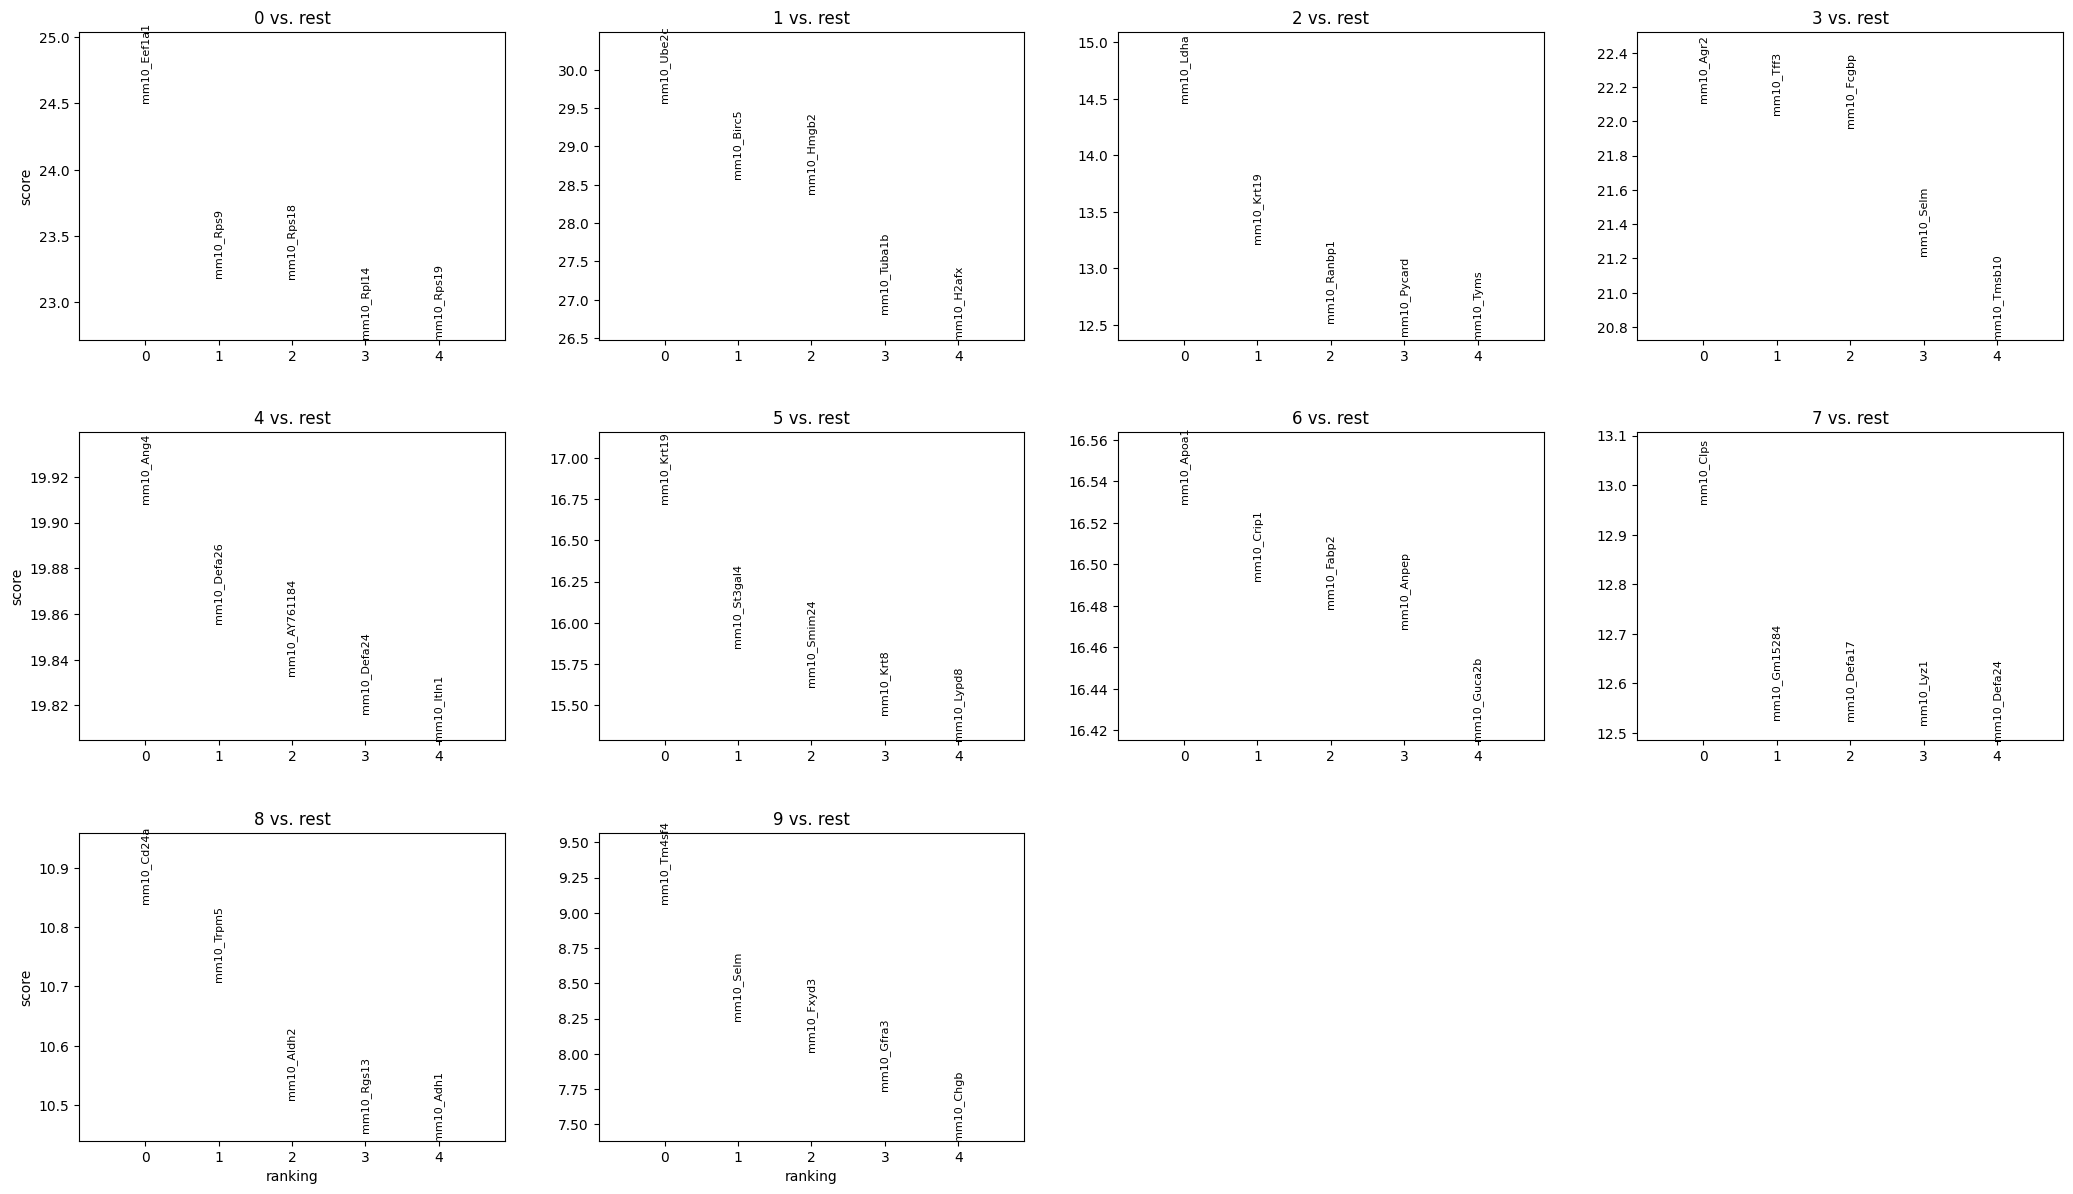

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)

# 11. 여러 샘플의 병합
- GSE92332는 조건별로 수십 개의 (barcodes, genes, matrix) 파일이 존재.
- 이들을 각각 로드한 뒤, scanpy의 concatenate 기능 등을 이용하여 하나의 AnnData로 합칠 수 있음.
- 다양한 조건(샘플)별로 분리된 (barcodes, genes, matrix) 파일을 모두 읽어서,
scanpy의 concatenate로 병합 후 일괄 분석할 수 있음.

In [ ]:
import os

sample_paths = [
    './data/Haber-et-al_mouse-intestinal-epithelium/GSE92332_RAW/GSM2836573',
    './data/Haber-et-al_mouse-intestinal-epithelium/GSE92332_RAW/GSM2836574',
]

adatas = []

for sp in sample_paths:
    tmp = get_adata(sp)
    tmp.var_names_make_unique()
    adatas.append(tmp)

adata_merged = adatas[0].concatenate(*adatas[1:], join='outer')
print(adata_merged)

AnnData object with n_obs × n_vars = 4554 × 27998
    obs: 'batch'


<ipython-input-55-6bde6fcf00e9>:15: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_merged = adatas[0].concatenate(*adatas[1:], join='outer')
